Notebook for testing the trained models.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
import pandas as pd
import torch.nn.functional as F

from lib.utils import get_free_gpu, load_lizard, debug
from lib.utils_vis import make_seed, to_rgb, damage_batch
from lib.EnergyCAModel import EnergyCAModel
from lib.CAModel import CAModel
from lib.utils import animate_steps
model_dir = 'models/'

# Initialization

In [2]:

torch.backends.cudnn.benchmark = True # Speeds up stuff
torch.backends.cudnn.enabled = True

## General Parameters ##
global_params = {
    'CHANNEL_N': 16,
    'TARGET_PADDING': 16,
    'TARGET_SIZE': 40,
    'IMG_SIZE': 72,
    'MIN_STEPS': 64,
    'MAX_STEPS': 128,
}

## General Training Parameters ##
# choose cuda device with the least amount of current memory usage
training_params = {
    'lr': 2e-3,
    'lr_gamma': 0.9999,
    'betas': (0.5, 0.5),
    'n_epoch': 10000,
    'batch_size': 8,
    'grad_clip': 1.0,
    'device': torch.device('cuda:{}'.format(get_free_gpu()) if torch.cuda.is_available() else 'cpu'),
    'history_save_dir': 'histories/',
    'model_save_dir': 'models/gumbel/', ###
}

ca_params = {"CELL_FIRE_RATE": 0.5}
number_of_batches = 1#10


Getting free GPU...
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 | 44% | 91% |
|  4 |  0% |  0% |
Using GPU:  0


/nfs_home/charneca/miniconda3/envs/nca/lib/python3.9/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU4 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


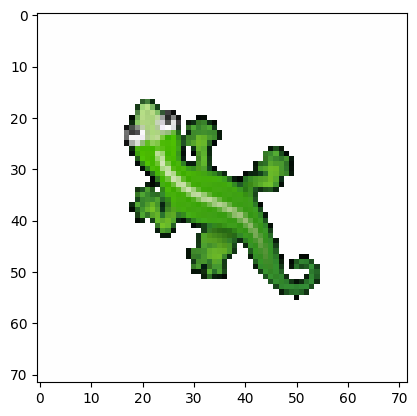

In [3]:
# Load target emoji
target_img = load_lizard('data/lizard_clean.png')
p = global_params['TARGET_PADDING']
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))

# Create initial state
seed = make_seed((h, w), global_params['CHANNEL_N'])
x0 = np.repeat(seed[None, ...], training_params["batch_size"], 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(training_params['device'])

plt.imshow(to_rgb(pad_target.detach().cpu()[0]))

# Load gumbel test model

In [4]:
# Load model
max_steps = global_params['MAX_STEPS']*5
beta_energy = 1e-9
model_name = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/EnergyCA_gumbel_EnergyLoss_betaEnergy{beta_energy:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
model.load_state_dict(torch.load(model_name))
model.eval()


EnergyCAModel(
  (fc0): Linear(in_features=48, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=16, bias=False)
  (fireRate_layer): Linear(in_features=128, out_features=1, bias=True)
)

x_steps.shape = torch.Size([640, 8, 72, 72, 16])


/tmp/ipykernel_372774/2347808157.py:12: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]


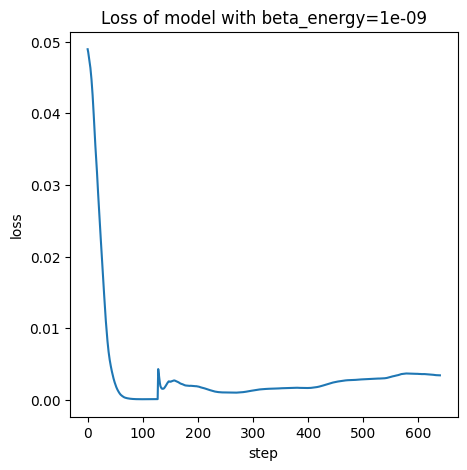

In [12]:
# Run the model
with torch.no_grad():
    x_steps, fireRates_steps, update_grid_steps = model(x0, steps=max_steps, 
                                    damage_at_step=global_params["MAX_STEPS"], damage_location='center', damaged_in_batch=training_params["batch_size"],
                                    get_update_grid = True)

# compute the loss (mean accross the batch)
x_steps = x_steps.detach().cpu()
fireRates_steps = fireRates_steps.detach().cpu()
update_grid_steps = update_grid_steps.detach().cpu()
debug("x_steps.shape")
losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.title(f'Loss of model with beta_energy={beta_energy:.0e}')
plt.show()

In [13]:
debug("update_grid_steps.shape")

update_grid_steps.shape = torch.Size([640, 8, 72, 72])


In [14]:
# animate
animate_steps(
    to_rgb(x_steps),
    fireRates_steps,
    update_grid_steps,
)

# Compare models through time (gumbel)

In [4]:
# Load all models
max_steps = global_params["MAX_STEPS"]*5
gumbel_dir = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(gumbel_dir)
model_names = [m for m in model_names if m.endswith('.pth')]
models = []
for m in model_names:
    model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
    model.load_state_dict(torch.load(os.path.join(gumbel_dir, m)))
    model.eval()
    models.append(model)

print("Loaded {} models from {}".format(len(models), gumbel_dir))
                   

Loaded 8 models from models/gumbel_maxSteps128/


In [6]:
# get model params
params = {
    'betaEnergy': [],
}

for m in model_names:
    for param in params:
        params[param].append(float(m.split(param)[1].split('_')[0]))

debug("params")

params = {'betaEnergy': [0.0, 1e-09, 2e-09, 3e-09, 4e-09, 5e-09, 2e-10, 5e-10]}


In [7]:
debug("x0.shape")

x0.shape = torch.Size([8, 72, 72, 16])


In [8]:
# Run the models
# Repeat number_of_batches times, to get better statistics
x_steps_models = []
fireRates_steps_models = []
update_grid_steps_models = []
for m, model in enumerate(models):
    x_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
    fireRates_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    update_grid_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    for i in range(number_of_batches):
        # clean previous print and replace with new one
        print(" "*100, end='\r')
        print(f"Running model {model_names[m]} batch {i+1}/{number_of_batches}", end='\r')
        with torch.no_grad():
            x_steps, fireRates_steps, update_grid_steps = model(x0, steps=max_steps, get_update_grid = True)

        x_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps.detach().cpu()
        fireRates_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = fireRates_steps.detach().cpu()
        update_grid_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = update_grid_steps.detach().cpu()
    x_steps_models.append(x_steps_batch)
    fireRates_steps_models.append(fireRates_steps_batch)
    update_grid_steps_models.append(update_grid_steps_batch)

        

In [7]:
debug("x_steps.shape")
debug("fireRates_steps.shape")
debug("len(x_steps_models)")
debug("x_steps_models[0].shape")

x_steps.shape = torch.Size([640, 8, 72, 72, 16])
fireRates_steps.shape = torch.Size([640, 8, 72, 72])
len(x_steps_models) = 10
x_steps_models[0].shape = torch.Size([640, 80, 72, 72, 16])


In [13]:

# Plot losses of all models through time, averaging over the batch
losses_models = []
avg_fireRate_models = []
for i,x_steps in enumerate(x_steps_models):
    loss = [F.mse_loss(x_steps[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]

    # compute average fireRate only for live cells (channel 3 > 0.1)
    avg_fireRate = [torch.mean(fireRates_steps_models[i][k,:,:,:][x_steps[k,:,:,:,3] > 0.1]).item() for k in range(max_steps)]
    losses_models.append(loss)
    avg_fireRate_models.append(avg_fireRate)


/tmp/ipykernel_395253/545589251.py:5: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = [F.mse_loss(x_steps[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]


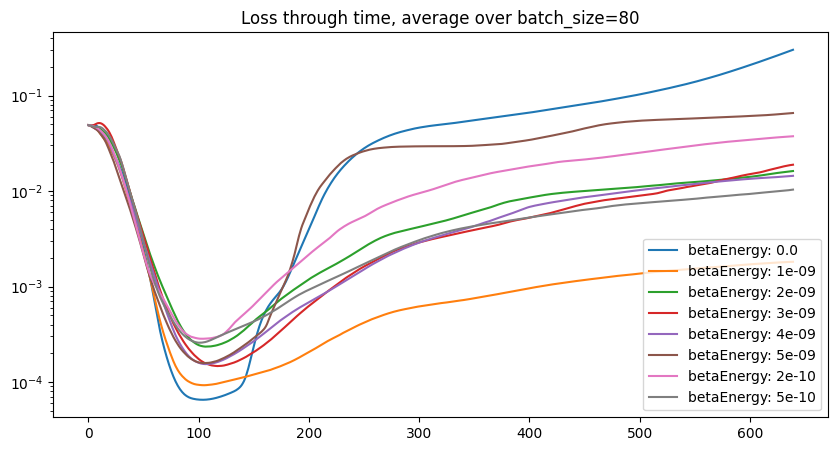

In [9]:
# plot the losses. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,5))
for i, l in enumerate(losses_models):
    plt.plot(l, label="betaEnergy: {}".format(params['betaEnergy'][i]))
    
plt.legend()
plt.title(f"Loss through time, average over batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
plt.yscale('log')
plt.show()



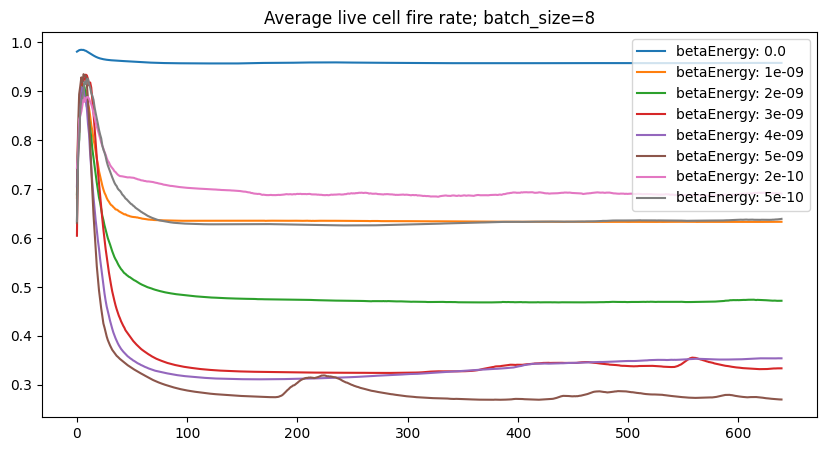

In [14]:
# plot the mean updates. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,5))
for i, m in enumerate(avg_fireRate_models):
    plt.plot(m, label="betaEnergy: {}".format(params['betaEnergy'][i]))
    
plt.legend()
plt.title(f"Average live cell fire rate; batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
#plt.yscale('log')
plt.show()



In [23]:
f"{0.634:.2e}"

'6.34e-01'

In [18]:
print("Avg final fire rate of best model (betaEnergy = 1e-9)")
debug("np.mean(avg_fireRate_models[1][200:])")

Avg final fire rate of best model (betaEnergy = 1e-9)
np.mean(avg_fireRate_models[1][200:]) = 0.633791124549779


Text(0.5, 0.98, 'Batch index = 8')

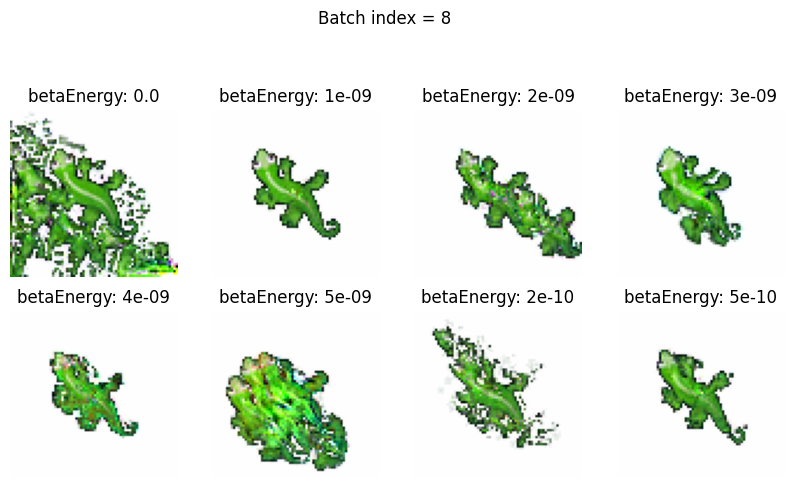

In [11]:
# Visualize a final state for each model in a grid
# Each model should have a label with the params used to train the model

# get the final state for each model
batch_i = np.random.randint(number_of_batches*training_params["batch_size"])
x_final_models = [x_steps_models[i][-1,batch_i,:,:,:] for i in range(len(x_steps_models))]
x_final_models = torch.stack(x_final_models)

# plot the final state for each model
plt.figure(figsize=(10, 10))
for i in range(x_final_models.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_rgb(x_final_models[i]))
    plt.title(f"betaEnergy: {params['betaEnergy'][i]}")
    plt.axis('off')

plt.suptitle("Batch index = {}".format(batch_i))



In [10]:
# Save each loss to a .csv file, each file will have the name of the model.
# The 1st column is named "step" and the 2nd column is named "loss"

for i, l in enumerate(losses_models):
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': l})
    df.to_csv(os.path.join('test_losses/', model_names[i].split('.')[0] + '.csv'), index=False)

# Load normal CA model

In [15]:
# Load CA model
max_steps = global_params["MAX_STEPS"]*5
no_gumbel_dir = model_dir + f'no_gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_name = f'CA_constFireRate{ca_params["CELL_FIRE_RATE"]:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = CAModel(global_params["CHANNEL_N"], ca_params['CELL_FIRE_RATE'], training_params["device"])
model.load_state_dict(torch.load(no_gumbel_dir + model_name))
model.eval()

CAModel(
  (fc0): Linear(in_features=48, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=16, bias=False)
)

x_steps_total.shape = torch.Size([640, 8, 72, 72, 16])
update_grid_steps_total.shape = torch.Size([640, 8, 72, 72])


/tmp/ipykernel_372774/1175991461.py:23: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ca_losses = [F.mse_loss(x_steps_total[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]


mean_updates.shape = (640,)


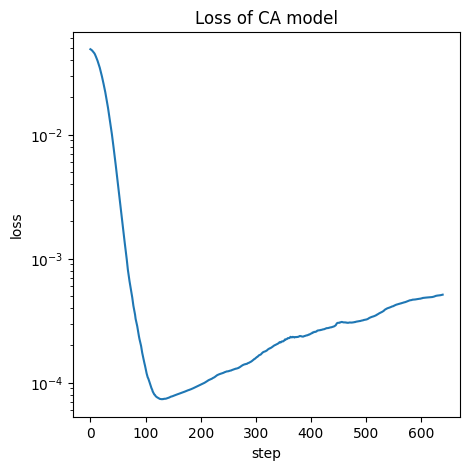

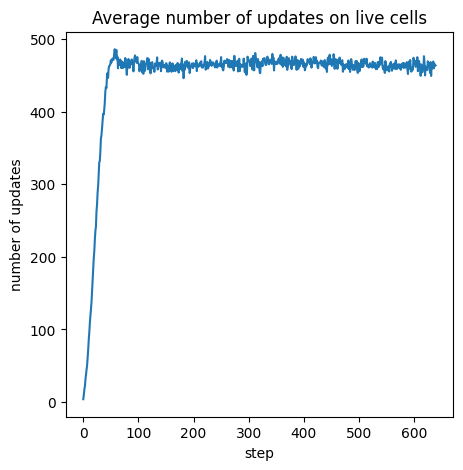

In [24]:
# Run model for max_steps
x_steps_total = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
update_grid_steps_total = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:-1])

for i in range(number_of_batches): 
    x_steps = []
    update_grid_steps = []
    for j in range(max_steps):
        if j==0:
            x = x0
        with torch.no_grad():
            x, update_grid = model(x, steps=1, get_update_grid = True)
        x_steps.append(x.detach().cpu())
        update_grid_steps.append(update_grid.detach().cpu())
    x_steps = torch.stack(x_steps)
    update_grid_steps = torch.stack(update_grid_steps)
    x_steps_total[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps
    update_grid_steps_total[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = update_grid_steps

debug("x_steps_total.shape")
debug("update_grid_steps_total.shape")
# compute the loss (mean accross the batch)
ca_losses = [F.mse_loss(x_steps_total[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]

# compute mean number of updates per step
mean_updates = update_grid_steps_total.sum(dim=(2,3)).mean(dim=1).numpy()
debug("mean_updates.shape")

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(ca_losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Loss of CA model')
plt.show()

# plot the mean updates
plt.figure(figsize=(5, 5))
plt.plot(mean_updates)
plt.xlabel('step')
plt.ylabel('number of updates')
plt.title('Average number of updates on live cells')
plt.show()


In [18]:
# show animation
animate_steps(
    to_rgb(x_steps),
    update_grid_steps
)


In [31]:
# save loss to csv, 1st column is the step, 2nd column is the loss, the file name has the model name
loss_df = pd.DataFrame({'step': np.arange(max_steps), 'loss': ca_losses})
loss_df.to_csv(os.path.join('test_losses', model_name.split('.')[0] + '.csv'), index=False)


['EnergyCA_gumbel_EnergyLoss_betaEnergy0e+00_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy1e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy3e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy4e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-10_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-10_maxSteps128_epoch10000.csv', 'CA_constFireRate5e-01_maxSteps128_epoch10000.csv']


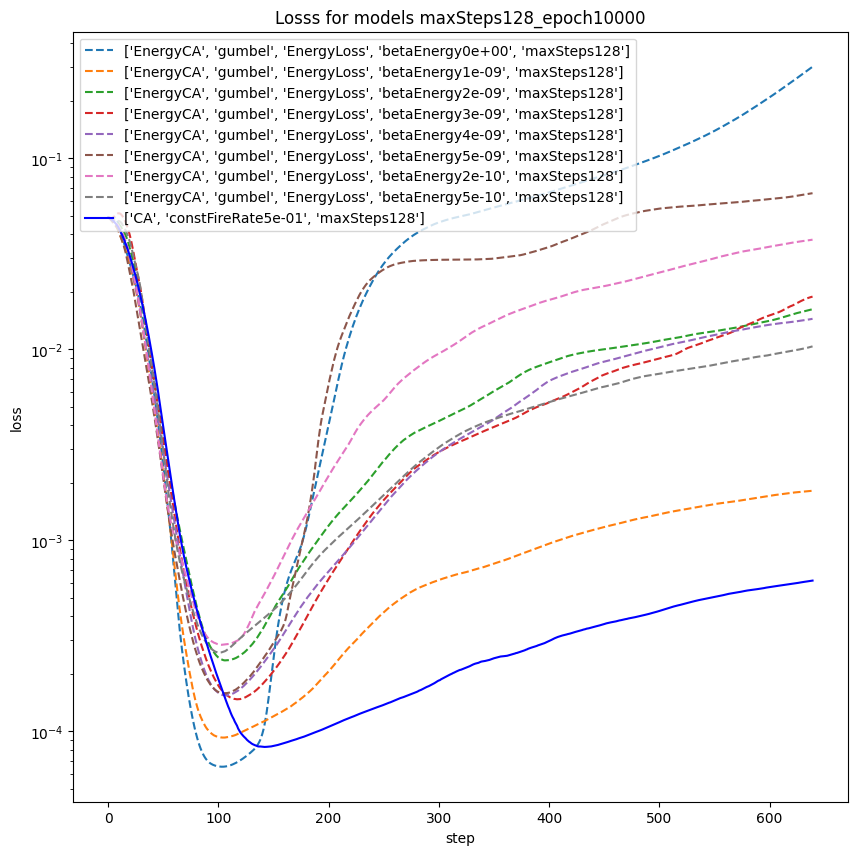

In [12]:
# Plot in the same axis as all the .csv files in the /test_losses folder.
# The 1st column of each csv file is the step, the 2nd column is the loss, but the columns are not named in the file.
file_ending = f'maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.csv'
file_names = [t for t in os.listdir('test_losses') if t.endswith(file_ending)]
print(file_names)
test_losses = [pd.read_csv(os.path.join('test_losses', t)) for t in file_names]

# plot the test losses
plt.figure(figsize=(10,10))
for i, t in enumerate(test_losses):
    if 'EnergyCA' in file_names[i]:
        plt.plot(t['step'], t['loss'],'--', label=file_names[i].split('_')[:-1])
    else:
        plt.plot(t['step'], t['loss'],'b-', label=file_names[i].split('_')[:-1])
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Losss for models ' + file_ending.split('.')[0])
plt.legend()
plt.show()



# Create table with params vs loss

In [ ]:
# Sort models in /models by the average loss of the last 100 epochs. This loss history is saved in the /histories folder, as a .csv val, in the loss_rec_val column.

model_names = os.listdir(model_dir)
model_names = [m for m in model_names if m.endswith('.pth')]

# substitute the _epoch8000.pth with _history.csv
hist_names = [m.replace('_epoch8000.pth', '_history.csv') for m in model_names]

# load the histories into dataframes. Each model name has the numerical hyperpameters in it, so we'll create a dataframe with the columns:
# minFireRate
# betaEnergy
# avgLoss_last100

# first, get parameters from model names
params = {
    'minFireRate': [],
    'betaEnergy': [],
}

for m in model_names:
    params['minFireRate'].append(float(m.split('minFireRate')[1].split('_')[0]))
    params['betaEnergy'].append(float(m.split('betaEnergy')[1].split('_')[0]))

print(params)
# now, load the histories
histories = []
for h in hist_names:
    histories.append(pd.read_csv(os.path.join(training_params['history_save_dir'], h)))

# now, create the dataframe
df = pd.DataFrame(params)

# now, add the average loss of the last 100 epochs
avgLoss_last100 = []
for h in histories:
    avgLoss_last100.append(h['loss_rec_val'].iloc[-100:].mean())

df['avgLoss_last100'] = avgLoss_last100

# now, sort by avgLoss_last100
df = df.sort_values(by='avgLoss_last100')
df




{'minFireRate': [0.01, 0.05, 0.1, 0.2, 0.01, 0.05, 0.1, 0.2, 0.01, 0.05, 0.1, 0.2], 'betaEnergy': [1e-07, 1e-07, 1e-07, 1e-07, 1e-06, 1e-06, 1e-06, 1e-06, 1e-05, 1e-05, 1e-05, 1e-05]}


minFireRate    betaEnergy  avgLoss_last100
3          0.20  1.000000e-07         0.000850
7          0.20  1.000000e-06         0.000953
11         0.20  1.000000e-05         0.001138
6          0.10  1.000000e-06         0.001538
2          0.10  1.000000e-07         0.001751
10         0.10  1.000000e-05         0.002246
5          0.05  1.000000e-06         0.002468
1          0.05  1.000000e-07         0.002569
9          0.05  1.000000e-05         0.002973
4          0.01  1.000000e-06         0.004059
8          0.01  1.000000e-05         0.006038
0          0.01  1.000000e-07         0.018023

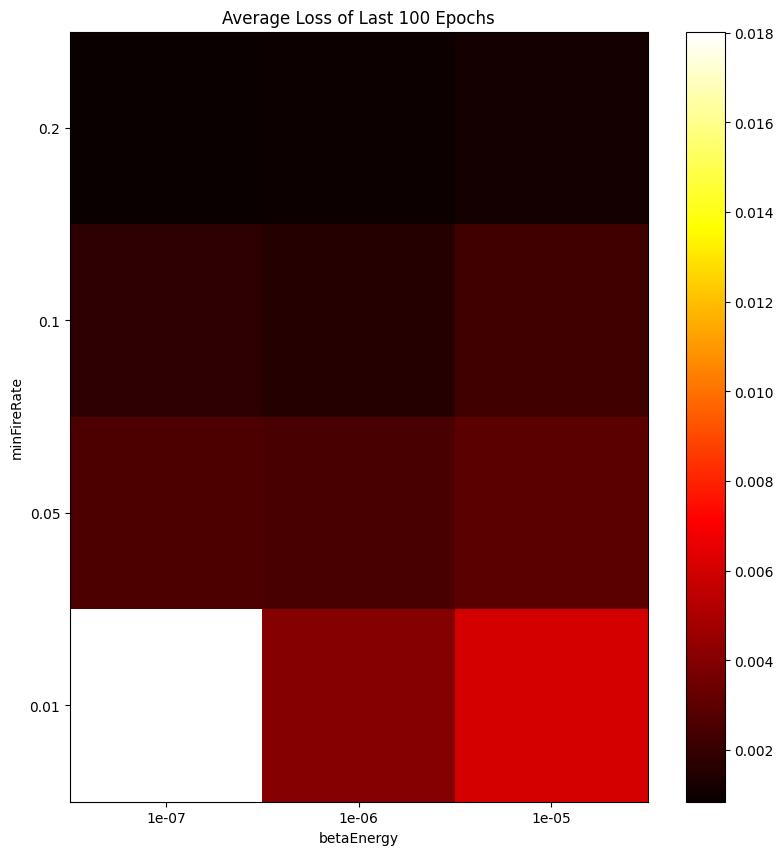

In [ ]:
# Now create a table, where the rows are the minFireRate, and the columns are the betaEnergy. The values are the avgLoss_last100

# first, create the table
table = np.zeros((len(df['minFireRate'].unique()), len(df['betaEnergy'].unique())))
# now, fill it
for i, m in enumerate(df['minFireRate'].unique()):
    for j, b in enumerate(df['betaEnergy'].unique()):
        table[i, j] = df.loc[(df['minFireRate'] == m) & (df['betaEnergy'] == b), 'avgLoss_last100'].values[0]

# now, plot it
plt.figure(figsize=(10, 10))
plt.imshow(table, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(len(df['betaEnergy'].unique())), df['betaEnergy'].unique())
plt.yticks(np.arange(len(df['minFireRate'].unique())), df['minFireRate'].unique())
plt.xlabel('betaEnergy')
plt.ylabel('minFireRate')
plt.title('Average Loss of Last 100 Epochs')
plt.colorbar()
plt.show()


# Damage resistance

In [68]:
# Load all models
max_steps = global_params["MAX_STEPS"]*2
gumbel_dir = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(gumbel_dir)
model_names = [m for m in model_names if m.endswith('.pth')]
models = []
for m in model_names:
    model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
    model.load_state_dict(torch.load(os.path.join(gumbel_dir, m)))
    model.eval()
    models.append(model)

print("Loaded {} models from {}".format(len(models), gumbel_dir))

# Damage params
damage_at_step= global_params["MAX_STEPS"]
damage_location='tail' #['random', 'center', 'head', 'leg1', 'tail'] 
damaged_in_batch= training_params["batch_size"]
                   

Loaded 8 models from models/gumbel_maxSteps128/


In [69]:
# get model params
params = {
    'betaEnergy': [],
}

for m in model_names:
    for param in params:
        params[param].append(float(m.split(param)[1].split('_')[0]))

debug("params")

params = {'betaEnergy': [0.0, 1e-09, 2e-09, 3e-09, 4e-09, 5e-09, 2e-10, 5e-10]}


In [70]:
# Run the models
# Repeat number_of_batches times, to get better statistics
x_steps_models = []
fireRates_steps_models = []
for m, model in enumerate(models):
    x_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
    fireRates_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    
    for i in range(number_of_batches):
        # clean previous print and replace with new one
        print(" "*100, end='\r')
        print(f"Running model {model_names[m]} batch {i+1}/{number_of_batches}", end='\r')
        with torch.no_grad():
            x_steps, fireRates_steps = model(x0, steps=max_steps,
                                             damage_at_step=damage_at_step, damage_location=damage_location, 
                                             damaged_in_batch=damaged_in_batch)

        x_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps.detach().cpu()
        fireRates_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = fireRates_steps.detach().cpu()
    
    x_steps_models.append(x_steps_batch)
    fireRates_steps_models.append(fireRates_steps_batch)

        

In [71]:
debug("x_steps.shape")
debug("fireRates_steps.shape")
debug("len(x_steps_models)")
debug("x_steps_models[0].shape")

x_steps.shape = torch.Size([256, 8, 72, 72, 16])
fireRates_steps.shape = torch.Size([256, 8, 72, 72])
len(x_steps_models) = 8
x_steps_models[0].shape = torch.Size([256, 80, 72, 72, 16])


In [72]:

# Plot losses of all models through time, averaging over the batch
losses_models = []
for x_steps in x_steps_models:
    loss = [F.mse_loss(x_steps[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    losses_models.append(loss)


/tmp/ipykernel_300876/653198729.py:4: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = [F.mse_loss(x_steps[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]


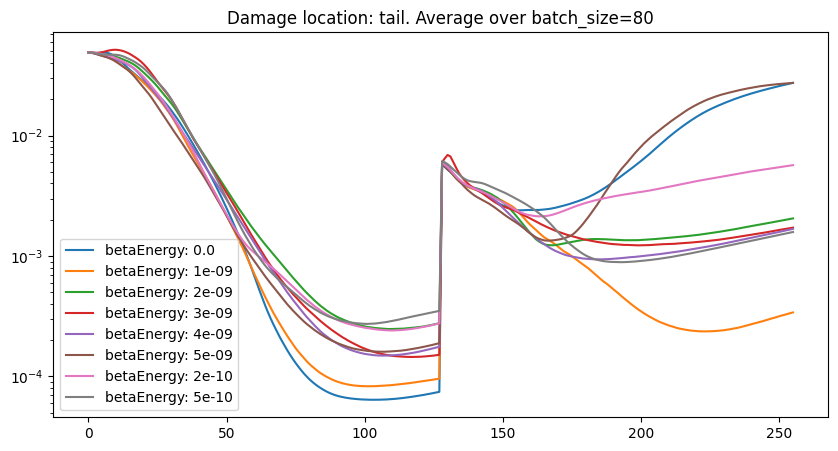

In [73]:
# plot the losses. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,5))
for i, l in enumerate(losses_models):
    plt.plot(l, label="betaEnergy: {}".format(params['betaEnergy'][i]))
    
plt.legend()
plt.title(f"Damage location: {damage_location}. Average over batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
plt.yscale('log')
plt.show()



Text(0.5, 0.98, 'Damage location: tail; Batch index = 31')

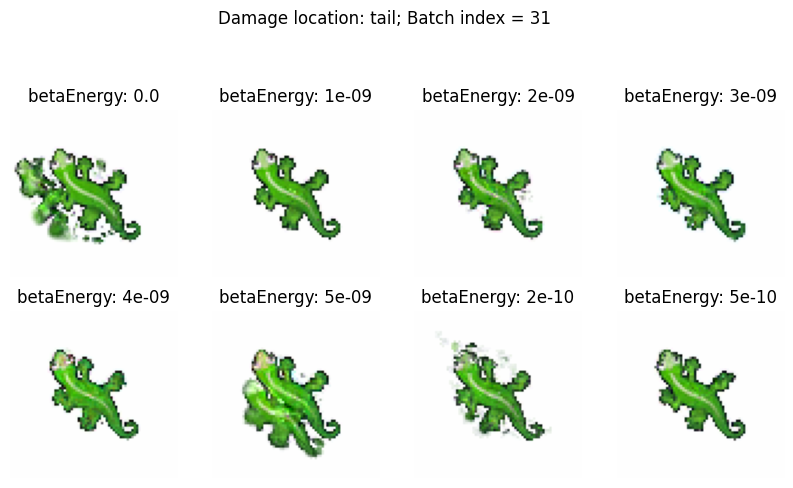

In [74]:
# Visualize a final state for each model in a grid
# Each model should have a label with the params used to train the model

# get the final state for each model
batch_i = np.random.randint(number_of_batches*training_params["batch_size"])
x_final_models = [x_steps_models[i][-1,batch_i,:,:,:] for i in range(len(x_steps_models))]
x_final_models = torch.stack(x_final_models)

# plot the final state for each model
plt.figure(figsize=(10, 10))
for i in range(x_final_models.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_rgb(x_final_models[i]))
    plt.title(f"betaEnergy: {params['betaEnergy'][i]}")
    plt.axis('off')

plt.suptitle("Damage location: {}; Batch index = {}".format(damage_location, batch_i))



In [75]:
# Save each loss to a .csv file, each file will have the name of the model.
# The 1st column is named "step" and the 2nd column is named "loss"

for i, l in enumerate(losses_models):
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': l})
    df.to_csv(os.path.join(f'damage_losses/{damage_location}/', model_names[i].split('.')[0] + '.csv'), index=False)

# Load normal CA model (for damage)

In [46]:
# Load CA model
max_steps = global_params["MAX_STEPS"]*2
no_gumbel_dir = model_dir + f'no_gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_name = f'CA_constFireRate{ca_params["CELL_FIRE_RATE"]:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = CAModel(global_params["CHANNEL_N"], ca_params['CELL_FIRE_RATE'], training_params["device"])
model.load_state_dict(torch.load(no_gumbel_dir + model_name))
model.eval()

# Damage params
damage_at_step= global_params["MAX_STEPS"]
damage_location='tail' #['random', 'center', 'head', 'leg1', 'tail'] 
damaged_in_batch= training_params["batch_size"]

x_steps_total.shape = torch.Size([256, 80, 72, 72, 16])


/tmp/ipykernel_300876/4030091241.py:21: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ca_losses = [F.mse_loss(x_steps_total[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]


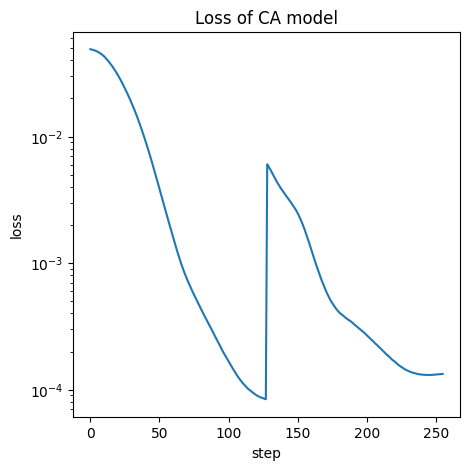

In [47]:
# Run model for max_steps
x_steps_total = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
for i in range(number_of_batches): 
    x_steps = []
    for j in range(max_steps):
        if j==0:
            x = x0
        if j==damage_at_step:
            x = damage_batch(x, 
                            training_params["device"],
                            img_size = 72, 
                            damage_location = damage_location, damaged_in_batch = damaged_in_batch)
        with torch.no_grad():
            x = model(x, steps=1)
        x_steps.append(x.detach().cpu())
    x_steps = torch.stack(x_steps)
    x_steps_total[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps

debug("x_steps_total.shape")
# compute the loss (mean accross the batch)
ca_losses = [F.mse_loss(x_steps_total[k,:,:,:,:4], pad_target).item() for k in range(max_steps)]

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(ca_losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Loss of CA model')
plt.show()

In [48]:
# show animation
animate_steps(
    to_rgb(x_steps[:,1:]),
)


In [49]:
# save loss to csv, 1st column is the step, 2nd column is the loss, the file name has the model name
loss_df = pd.DataFrame({'step': np.arange(max_steps), 'loss': ca_losses})
loss_df.to_csv(os.path.join(f'damage_losses/{damage_location}/', model_name.split('.')[0] + '.csv'), index=False)


['CA_constFireRate5e-01_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy0e+00_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy1e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy3e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy4e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-09_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy2e-10_maxSteps128_epoch10000.csv', 'EnergyCA_gumbel_EnergyLoss_betaEnergy5e-10_maxSteps128_epoch10000.csv']


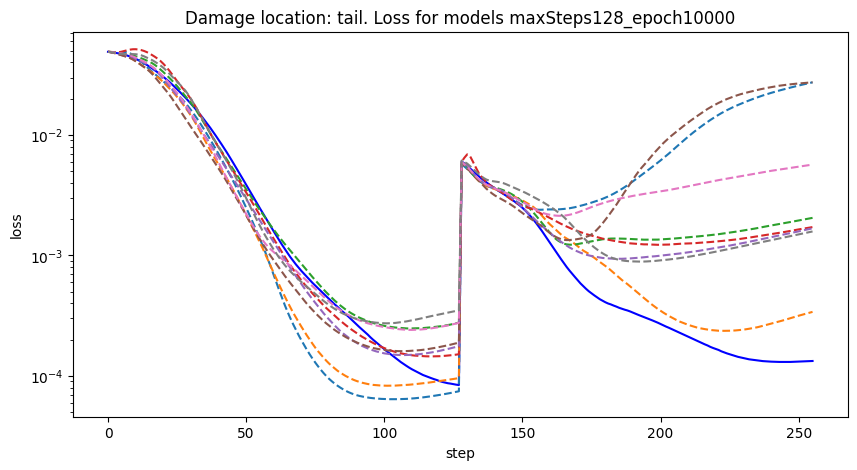

In [81]:
# Plot in the same axis as all the .csv files in the /test_losses folder.
# The 1st column of each csv file is the step, the 2nd column is the loss, but the columns are not named in the file.
damage_location = 'tail'
file_ending = f'maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.csv'
file_names = [t for t in os.listdir(f'damage_losses/{damage_location}') if t.endswith(file_ending)]
print(file_names)
test_losses = [pd.read_csv(os.path.join(f'damage_losses/{damage_location}', t)) for t in file_names]

# plot the test losses
plt.figure(figsize=(10,5))
for i, t in enumerate(test_losses):
    if 'EnergyCA' in file_names[i]:
        plt.plot(t['step'], t['loss'],'--', label=file_names[i].split('_')[:-1])
    else:
        plt.plot(t['step'], t['loss'],'b-', label=file_names[i].split('_')[:-1])
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title(f'Damage location: {damage_location}. Loss for models ' + file_ending.split('.')[0])
#plt.legend()
plt.show()

